# On-the-fly ggame computation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import streamlit as st
import sklearn.metrics.pairwise as sklpw
from PIL import Image
from fuzzywuzzy import fuzz
import re

In [2]:
# LOAD DATA
allgamedata_df = pd.read_pickle('datasources/bgg_filters.pkl') # USE FOR URLS and FILTERS
allgamedata_df = allgamedata_df.astype({'game_rank':'int32'},copy=True)
allgamedocvects = np.load('datasources/allgamedocvects_v3.npz')['arr_0']
finalgamelist_df = pd.read_pickle('datasources/finalgamelist_df.pkl')
#finalgamelist_df =  finalgamelist_df.astype({'game_rank':'int32'},copy=True)
#finalgamelist_df['num_raters'] = [list(allgamedata_df.loc[allgamedata_df['game_name']==g,'num_raters'])[0] for g in finalgamelist_df['game_name']]
#finalgamelist_df.reset_index(drop=True,inplace=True) # So that row ids are indices to gamevector array

# FOr gameplay-based vectors
bgg_gameplay_df = pd.read_pickle('datasources/bgg_gameplayfeatures.pkl')
bgg_gameplay_df.dropna(inplace=True) # Some not-NAs here...
bgg_gameplay_df.reset_index(drop=True,inplace=True)
allgamePLAYdocvects = np.array(bgg_gameplay_df.iloc[:,1:]) # Create right here

## Verify data sizes

In [3]:
print('finalgamelist_df {} should match allgamedocvects {}'.format(finalgamelist_df.shape,allgamedocvects.shape))

finalgamelist_df (18561, 4) should match allgamedocvects (18561, 100)


In [4]:
print('bgg_gameplay_df {} should match allgamePLAYdocvects {}'.format(bgg_gameplay_df.shape,allgamePLAYdocvects.shape))

bgg_gameplay_df (18500, 272) should match allgamePLAYdocvects (18500, 271)


In [5]:
finalgamelist_df.columns

Index(['idx', 'game_rank', 'game_name', 'num_raters'], dtype='object')

In [6]:
allgamedata_df.columns

Index(['game_rank', 'geek_rating', 'avg_rating', 'num_raters', 'game_name',
       'game_year', 'bgg_url', 'numplayersmin', 'gamedurmin', 'gamedurmax',
       'agemin'],
      dtype='object')

In [7]:
# FUNCTIONS

def getcompute_similar_by_gameplay(gamename,allgamedata_df, bgg_gameplay_df, allgamePLAYdocvects):
    # Get game rank from game name, and matrix index from rank
  
    gamerank = list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'game_rank'])[0]
    gamerank = int(gamerank)
    gamerank_idx = list(bgg_gameplay_df.index[bgg_gameplay_df['game_rank']==gamerank])[0]
    #print(gamename, gamerank_idx)
    
    mygamePLAYvector = allgamePLAYdocvects[gamerank_idx,:] 
    mygamePLAYvector = mygamePLAYvector.reshape(-1,1)

    mysimilarities_gp = []
    for t in range(0,allgamePLAYdocvects.shape[0]):
        currgamevect_gp = allgamePLAYdocvects[t,:]
        currgamevect_gp = currgamevect_gp.reshape(-1,1)
        dum = sklpw.cosine_similarity(currgamevect_gp.T,mygamePLAYvector.T)
        mysimilarities_gp.append(dum[0][0])
    mycompleteGPsimlist_df = pd.concat((pd.DataFrame({'game_rank':bgg_gameplay_df['game_rank']}),pd.DataFrame({'GameplaySimilarity':mysimilarities_gp})),axis=1)
    return mycompleteGPsimlist_df

def getcompute_similar_games(mygameid,mygamename,allgamedata_df,allgamedocvects,finalgamelist_df,bgg_gameplay_df, allgamePLAYdocvects,W1,W2,filt_dict):
    # Jun 13 added filt_dict input
    myvectid = mygameid
    mygamevector = allgamedocvects[myvectid,:]
    mygamevector= mygamevector.reshape(-1,1)
    mysimilarities = []
    for t in range(0,allgamedocvects.shape[0]):
        currgamevect = allgamedocvects[t,:]
        currgamevect = currgamevect.reshape(-1,1)
        dum = sklpw.cosine_similarity(currgamevect.T,mygamevector.T)
        mysimilarities.append(dum[0][0])
    mycompletesimlist_df = pd.concat((finalgamelist_df['game_rank'],finalgamelist_df['game_name'],pd.DataFrame({'Similarity':mysimilarities})),axis=1)
    #mycompletesimlist_df = pd.concat((finalgamelist_df['game_rank','game_name'],pd.DataFrame({'Similarity':mysimilarities})),axis=1)
    #Get this also for GAMEPLAY data
    mycompleteGPsimlist_df = getcompute_similar_by_gameplay(mygamename,allgamedata_df, bgg_gameplay_df, allgamePLAYdocvects)

    # PUt sim lists together
    mycompletesimlist_df  = mycompletesimlist_df.astype({'game_rank':'int32'},copy=True)
    mycompleteGPsimlist_df = mycompleteGPsimlist_df.astype({'game_rank':'int32'},copy=True)
    mycompletesimlist_df.set_index('game_rank',inplace=True)
    mycompleteGPsimlist_df.set_index('game_rank',inplace=True)
    # Do it
    myFINALsimlist_df = mycompletesimlist_df.join(mycompleteGPsimlist_df,how='inner')
    
    
    weightedsimilarity = (np.array(myFINALsimlist_df['Similarity'])*W1) + (np.array(myFINALsimlist_df['GameplaySimilarity'])*W2)
    myFINALsimlist_df['WghtdSimilarity'] = weightedsimilarity
    myFINALsimlist_df.sort_values(by='WghtdSimilarity',ascending=False,inplace=True)
    
    
    # NEW: Jun 13
    # Create DF with all the filter data
    dum=allgamedata_df.loc[[list(allgamedata_df.index[allgamedata_df['game_rank']==n])[0] for n in myFINALsimlist_df.index],:]
    dum = dum[[ 'avg_rating', 'num_raters', 'bgg_url', 'numplayersmin', 'gamedurmin','agemin']].copy()
    dum.reset_index(drop=True, inplace=True)
    # Add this into myFINALsimlist_df
    myFINALsimlist_df.reset_index(inplace=True)
    myFINALsimlist_df=pd.concat((myFINALsimlist_df,dum),axis=1)
    # Create filter
    myfilters = (myFINALsimlist_df['avg_rating']>=filt_dict.get('min_rating'))  &  (myFINALsimlist_df['numplayersmin']>=filt_dict.get('min_players'))  &  (myFINALsimlist_df['gamedurmin']>=filt_dict.get('min_dur'))
    # UPDATE myFINALsimlist_df
    myFINALsimlist_df = myFINALsimlist_df.loc[myfilters,:].copy()
    
    
    #MO: Jun 18: Add in SUPECOMBO. Sort right after
    avgratingfactor = myFINALsimlist_df.iloc[0,:]['avg_rating']/10 # SCALE by rating of game?
    dumsupercombo = np.array(myFINALsimlist_df['Similarity'] + myFINALsimlist_df['GameplaySimilarity'] + (myFINALsimlist_df['avg_rating']/10)*avgratingfactor + np.log10(myFINALsimlist_df['num_raters'])/5)/4
    myFINALsimlist_df['supercombo'] = dumsupercombo
    myFINALsimlist_df.sort_values(by='supercombo',inplace=True,ascending=False)
    myFINALsimlist_df.drop(index=0,inplace=True) # DROP THE MAIN COMPARISON GAME ALREADY
    myFINALsimlist_df.reset_index(drop=True,inplace=True)
    
    # Create output list
    # MO: New Jun 13 - check to make sure there are enough games!
    # MO: June 18: return FULL LIST, compute later
    if len(myFINALsimlist_df)>11:    
        mytop10simlist_df = myFINALsimlist_df[:10].copy()
    else:
        mytop10simlist_df = myFINALsimlist_df.copy()
    urllist=[]
    for gamename in mytop10simlist_df['game_name']:
        urllist.append(list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'bgg_url'])[0])
    #mytop10simlist_df = pd.DataFrame({'Game':mytop10simlist_df['game_name'],'Similarity':mytop10simlist_df['WghtdSimilarity'],'url':urllist})
    mytop10simlist_df = pd.DataFrame({'Game':mytop10simlist_df['game_name'],'url':urllist})
    mytop10simlist_df.reset_index(drop=True,inplace=True)
    mytop10simlist_df.index = mytop10simlist_df.index+1

    return mytop10simlist_df,myFINALsimlist_df
    
    
    
    #mycompletesimlist_df.sort_values(by='Similarity',ascending=False,inplace=True)
    #mytop10simlist_df = mycompletesimlist_df[1:11]
    # Create output list
    #urllist=[]
    #for gamename in mytop10simlist_df['gamename']:
    #    urllist.append(list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'bgg_url'])[0])
    #mytop10simlist_df = pd.DataFrame({'Game':mytop10simlist_df['gamename'],'Similarity':mytop10simlist_df['Similarity'],'url':urllist})
    #mytop10simlist_df.reset_index(drop=True,inplace=True)
    #mytop10simlist_df.index = mytop10simlist_df.index+1
    #return mytop10simlist_df


def get_real_name_fuzzy(usergamename,finalgamelist_df):
    # Clean up
    usergamename = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", usergamename)
    #usergamename = re.sub(r"\d+", "", usergamename) # Maybe dont remove numbers?
    gamename_matchlist = [fuzz.token_sort_ratio(x,usergamename) for x in finalgamelist_df['game_name']]
    possiblegame_idx  = [i for i, x in enumerate(gamename_matchlist) if x == max(gamename_matchlist)]
    possiblegame_idx = possiblegame_idx[0] # Get first, make it number
    #possiblegame_name = list(finalgamelist_df.loc[finalgamelist_df['idx']==possiblegame_idx,'gamename'])[0]
    possiblegame_name = finalgamelist_df.iloc[possiblegame_idx,2]
    #print('Best match: {}'.format(possiblegame_name))
    
    return possiblegame_name,max(gamename_matchlist)

def make_clickable(url,text): # Make liks in pd df for url in table
    return f'<a target="_blank" href="{url}">{text}</a>'

def streamlitify_df(df):
    # Get original URLS
    df['Game_link'] = [make_clickable(a,b) for a,b in zip(list(df['url']),list(df['Game']))]
    return df


#def get_final_filt_list()

In [8]:
# CREATES THE DEMO GAME LIST
allgamedata_df['numeric_ranks']=[int(x) for x in allgamedata_df['game_rank']]
topranked_df = pd.DataFrame(allgamedata_df.loc[allgamedata_df['numeric_ranks']<=50,'game_name']) # To go back n forth
topranked_df.sort_values(by='game_name',inplace=True)
topranked_idx = topranked_df.index
demogamelist_manual = ['Azul', 'Catan', 'Candy Land','Carcassonne','Cards Against Humanity', 'Clue','Pandemic', 'Scrabble','Taboo' ]
#demo_gamelist = tuple(list(finalgamelist_df.loc[topranked_idx,'game_name']))
demo_gamelist = tuple(demogamelist_manual)

## Pretend some game selected

In [10]:
mygamename = 'catan'
# IF NAME IS UNCLEAR
mygamename,qltynum = get_real_name_fuzzy(mygamename,finalgamelist_df)
print('Best guess: {} (match score: {}/100)'.format(mygamename,str(qltynum)))
mygameid = list(finalgamelist_df.index[finalgamelist_df['game_name']==mygamename])[0] # Need INDEX, not idx
mygameurl=list(allgamedata_df.loc[allgamedata_df['game_name']==mygamename,'bgg_url'])[0]

Best guess: Catan (match score: 100/100)


In [11]:
W1=1 # Semantic
W2=1 # Feature
# FILTERS
filt_dict = {'min_rating':2,'min_players':1,'min_dur':1, 'min_numraters':1}
#min_rating = 7


In [12]:
mytop10simlist_df,myFINALsimlist_df = getcompute_similar_games(mygameid,mygamename,allgamedata_df,allgamedocvects,finalgamelist_df,bgg_gameplay_df, allgamePLAYdocvects,W1,W2,filt_dict)

In [ ]:
mygamevect_df = streamlitify_df(mytop10simlist_df)
dumtop10 = myFINALsimlist_df.copy().reset_index(drop=True)[:10]
dumtop10.index = dumtop10.index+1
mygamevect_df = pd.concat((mygamevect_df['Game_link'],dumtop10[['avg_rating','num_raters','numplayersmin','gamedurmin']]),axis=1)
mygamevect_df['num_raters']=np.round((np.log10(mygamevect_df['num_raters'])/5)*100).astype('int32')
mygamevect_df['numplayersmin']=mygamevect_df['numplayersmin'].astype('int32')
mygamevect_df['gamedurmin']=mygamevect_df['gamedurmin'].astype('int32')
mygamevect_df.rename(columns={'Game_link':'Game','avg_rating':'Avg. Rating','num_raters':'Popularity','numplayersmin':'Min. Number of Players','gamedurmin':'Min. Game Duration(min)'},inplace=True)
mygamevect_df
dumtop10

In [ ]:
mygamename_st_url = f'<a target="_blank" href="{mygameurl}">{mygamename}</a>'
mygamename_st_url

In [ ]:
mygameurl

#  ******** ROUGH STUFF ****************

In [30]:
import matplotlib.pyplot as plt
import sklearn.preprocessing as sklpre
from scipy import stats

In [9]:
finalgamelist_df.columns
#finalgamelist_df[['game_rank','game_name']]

Index(['idx', 'game_rank', 'game_name', 'num_raters'], dtype='object')

In [155]:
dumtop10 = myFINALsimlist_df.copy().reset_index(drop=True)[:10]
dumtop10.index = dumtop10.index+1
top10 = pd.concat((mygamevect_df['Game_link'],dumtop10[['avg_rating','num_raters','numplayersmin','gamedurmin']]),axis=1)

In [26]:
allgamedata_df.columns

Index(['game_rank', 'geek_rating', 'avg_rating', 'num_raters', 'game_name',
       'game_year', 'bgg_url', 'numplayersmin', 'gamedurmin', 'gamedurmax',
       'agemin', 'numeric_ranks'],
      dtype='object')

2.0718820073061255
0.07987535229006934


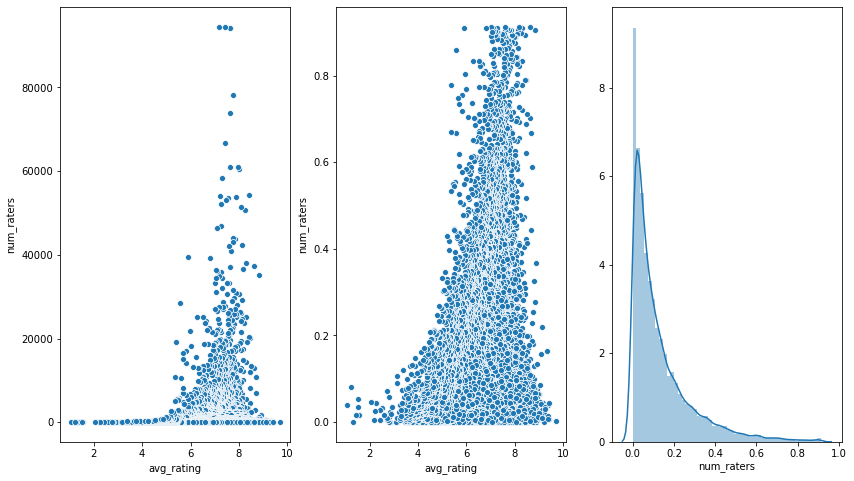

In [75]:
f,a = plt.subplots(1,3,figsize=(14,8))
print(np.median(np.log10(allgamedata_df['num_raters'])))
numratersfactor1 = np.log10(myFINALsimlist_df.iloc[0,:]['num_raters']) #Current
numratersfactor2 = abs(np.log10(allgamedata_df['num_raters'])-numratersfactor1) # Abs diff
numratersfactor2 = np.log10(allgamedata_df['num_raters']) * ( 1 - (numratersfactor2/np.max(numratersfactor2)))
numratersfactor =  numratersfactor2/5
#numratersfactor = (numratersfactor * (np.max(numratersfactor2) - numratersfactor2))/5 # 

#sns.distplot(np.log10(allgamedata_df['num_raters']))
#numratersfactor = (np.log10(allgamedata_df['num_raters']))
#numratersfactor = numratersfactor * (1 - ())
#numratersfactor = abs(numratersfactor-np.median(numratersfactor))/5
print(np.median(numratersfactor))
#sns.distplot(numratersfactor/5)
sns.scatterplot(allgamedata_df['avg_rating'],allgamedata_df['num_raters'],ax=a[0])
sns.scatterplot(allgamedata_df['avg_rating'],numratersfactor, ax=a[1])
sns.distplot(numratersfactor,ax=a[2])

In [143]:
mytop10simlist_df

,Game,url
1,Apples to Apples,https://boardgamegeek.com//boardgame/74/apples...
2,Joking Hazard,https://boardgamegeek.com//boardgame/193621/jo...
3,Dixit,https://boardgamegeek.com//boardgame/39856/dixit
4,Dixit: Odyssey,https://boardgamegeek.com//boardgame/92828/dix...
5,Sushi Go Party!,https://boardgamegeek.com//boardgame/192291/su...
6,Bring Your Own Book,https://boardgamegeek.com//boardgame/173441/br...
7,7 Wonders,https://boardgamegeek.com//boardgame/68448/7-w...
8,Race for the Galaxy,https://boardgamegeek.com//boardgame/28143/rac...
9,Skull,https://boardgamegeek.com//boardgame/92415/skull
10,Dixit: Journey,https://boardgamegeek.com//boardgame/121288/di...


In [142]:
myFINALsimlist_df

,game_rank,game_name,Similarity,GameplaySimilarity,WghtdSimilarity,avg_rating,num_raters,bgg_url,numplayersmin,gamedurmin,agemin,supercombo
5,4321,Apples to Apples,0.977594,0.826923,1.804517,5.83,17061.0,https://boardgamegeek.com//boardgame/74/apples...,4.0,30.0,12.0,0.749596
4,1934,Joking Hazard,0.968616,0.901775,1.870390,6.44,3862.0,https://boardgamegeek.com//boardgame/193621/jo...,3.0,30.0,18.0,0.742894
76,250,Dixit,0.980458,0.620393,1.600851,7.27,46879.0,https://boardgamegeek.com//boardgame/39856/dixit,3.0,30.0,8.0,0.742085
53,198,Dixit: Odyssey,0.976949,0.650945,1.627893,7.46,15343.0,https://boardgamegeek.com//boardgame/92828/dix...,3.0,30.0,8.0,0.727423
158,177,Sushi Go Party!,0.963708,0.587963,1.551670,7.48,18753.0,https://boardgamegeek.com//boardgame/192291/su...,2.0,20.0,8.0,0.713023
...,...,...,...,...,...,...,...,...,...,...,...,...
17963,18165,"Civil War Classics, Volume 1: The Battles of P...",0.891843,0.157019,1.048861,3.15,30.0,https://boardgamegeek.com//boardgame/10793/civ...,2.0,240.0,12.0,0.383006
17860,18407,Worlds of Heroes & Tyrants,0.902342,0.157019,1.059360,2.80,30.0,https://boardgamegeek.com//boardgame/1546/worl...,2.0,60.0,8.0,0.380416
18139,18629,The Civil War,0.833706,0.168529,1.002235,2.84,48.0,https://boardgamegeek.com//boardgame/11370/civ...,2.0,1200.0,12.0,0.376937
18174,17147,Amos Daragon,0.609788,0.157019,0.766807,4.73,32.0,https://boardgamegeek.com//boardgame/58339/amo...,3.0,30.0,9.0,0.337436


In [134]:
mytop10simlist_df

,Game,url
1,Apples to Apples,https://boardgamegeek.com//boardgame/74/apples...
2,Joking Hazard,https://boardgamegeek.com//boardgame/193621/jo...
3,Dixit,https://boardgamegeek.com//boardgame/39856/dixit
4,Dixit: Odyssey,https://boardgamegeek.com//boardgame/92828/dix...
5,Sushi Go Party!,https://boardgamegeek.com//boardgame/192291/su...
6,Bring Your Own Book,https://boardgamegeek.com//boardgame/173441/br...
7,7 Wonders,https://boardgamegeek.com//boardgame/68448/7-w...
8,Race for the Galaxy,https://boardgamegeek.com//boardgame/28143/rac...
9,Skull,https://boardgamegeek.com//boardgame/92415/skull
10,Dixit: Journey,https://boardgamegeek.com//boardgame/121288/di...


In [130]:
mytop10simlist_df

,Game,url,Game_link
1,Apples to Apples,https://boardgamegeek.com//boardgame/74/apples...,"<a target=""_blank"" href=""https://boardgamegeek..."
2,Joking Hazard,https://boardgamegeek.com//boardgame/193621/jo...,"<a target=""_blank"" href=""https://boardgamegeek..."
3,Dixit,https://boardgamegeek.com//boardgame/39856/dixit,"<a target=""_blank"" href=""https://boardgamegeek..."
4,Dixit: Odyssey,https://boardgamegeek.com//boardgame/92828/dix...,"<a target=""_blank"" href=""https://boardgamegeek..."
5,Sushi Go Party!,https://boardgamegeek.com//boardgame/192291/su...,"<a target=""_blank"" href=""https://boardgamegeek..."
6,Bring Your Own Book,https://boardgamegeek.com//boardgame/173441/br...,"<a target=""_blank"" href=""https://boardgamegeek..."
7,7 Wonders,https://boardgamegeek.com//boardgame/68448/7-w...,"<a target=""_blank"" href=""https://boardgamegeek..."
8,Race for the Galaxy,https://boardgamegeek.com//boardgame/28143/rac...,"<a target=""_blank"" href=""https://boardgamegeek..."
9,Skull,https://boardgamegeek.com//boardgame/92415/skull,"<a target=""_blank"" href=""https://boardgamegeek..."
10,Dixit: Journey,https://boardgamegeek.com//boardgame/121288/di...,"<a target=""_blank"" href=""https://boardgamegeek..."


In [ ]:
myFINALsimlist_df['supercombo'] = myFINALsimlist_df['Similarity']

In [61]:
dumsupercombo = np.array(myFINALsimlist_df['Similarity'] + myFINALsimlist_df['GameplaySimilarity'] + myFINALsimlist_df['avg_rating']/10 + np.log10(myFINALsimlist_df['num_raters'])/5)/4

In [62]:
dumsupercombo.mean()

0.6408287038693953

In [92]:
x=stats.boxcox(myFINALsimlist_df['Similarity'])
x[0].shape

(17680,)

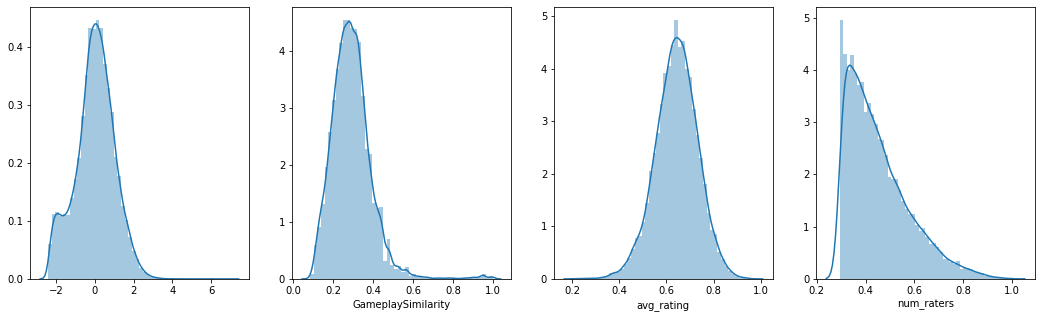

In [94]:
f,a = plt.subplots(1,4,figsize=(18,5))
sns.distplot(sklpre.scale(stats.boxcox(myFINALsimlist_df['Similarity'])[0]), ax=a[0])
#plt.title('SEM_sim')
sns.distplot(myFINALsimlist_df['GameplaySimilarity'], ax=a[1])
#plt.title('FTR_sim')
sns.distplot(myFINALsimlist_df['avg_rating']/10, ax=a[2])
#plt.title('Avg_rtng')
sns.distplot(np.log10(myFINALsimlist_df['num_raters'])/5, ax=a[3])
#plt.title('Num_raters')
plt.show()

In [100]:
x=myFINALsimlist_df.iloc[0,:]['avg_rating']
x

7.04

In [ ]:
myFINALsimlist_df = myFINALsimlist_df.iloc[0:10,:]
myFINALsimlist_df

In [ ]:
# Create DF with all the filter data
dum=allgamedata_df.loc[[list(allgamedata_df.index[allgamedata_df['game_rank']==n])[0] for n in myFINALsimlist_df.index],:]
dum = dum[[ 'avg_rating', 'bgg_url', 'numplayersmin', 'gamedurmin','agemin']].copy()
dum.reset_index(drop=True, inplace=True)
# Add this into myFINALsimlist_df
myFINALsimlist_df.reset_index(inplace=True)
myFINALsimlist_df=pd.concat((myFINALsimlist_df,dum),axis=1)
# Create filter
myfilters = (myFINALsimlist_df['avg_rating']>=filt_dict.get('min_rating'))  &  (myFINALsimlist_df['numplayersmin']>=filt_dict.get('min_players'))  &  (myFINALsimlist_df['gamedurmin']>=filt_dict.get('min_dur'))
# UPDATE myFINALsimlist_df
myFINALsimlist_df = myFINALsimlist_df.loc[myfilters,:].copy()

In [ ]:
mytop10simlist_df,myFINALsimlist_df = getcompute_similar_games(mygameid,mygamename,allgamedata_df,allgamedocvects,finalgamelist_df,bgg_gameplay_df, allgamePLAYdocvects,W1,W2,filt_dict)

In [ ]:
mytop10simlist_df

In [ ]:
urllist=[]
for gamename in mytop10simlist_df['game_name']:
    print(gamename)
    #urllist.append(list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'bgg_url'])[0])

In [ ]:
len(myFINALsimlist_df)

In [ ]:
allgamedata_df.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

In [ ]:
plt.hist(np.log10(allgamedata_df['num_raters']))

In [ ]:
sns.jointplot(np.log10(allgamedata_df['num_raters']),allgamedata_df['avg_rating'],kind='hex')


In [ ]:
allgamedata_df.describe()
dum =allgamedata_df.copy()
dum['lognumraters'] = np.log10(allgamedata_df['num_raters'])

In [ ]:
sns.pairplot(dum[['game_rank','avg_rating','lognumraters','game_year','numplayersmin']])

In [ ]:
finalgamelist_df

In [ ]:
allgamedata_df.columns

In [ ]:
finalgamelist_df['numraters'] = [list(allgamedata_df.loc[allgamedata_df['game_name']==g,'num_raters'])[0] for g in finalgamelist_df['game_name']]
                                      
                                      
                                      

In [ ]:
finalgamelist_df

In [7]:
finalgamelist_df.describe()

,idx,game_rank,num_raters
count,18561.000000,18561.000000,18561.000000
mean,9374.926890,9375.926890,861.334842
std,5449.683972,5449.683972,3491.090133
min,0.000000,1.000000,30.000000
25%,4656.000000,4657.000000,56.000000
50%,9339.000000,9340.000000,123.000000
75%,14073.000000,14074.000000,395.000000
max,18899.000000,18900.000000,94477.000000


In [8]:
allgamedata_df

,game_rank,geek_rating,avg_rating,num_raters,game_name,game_year,bgg_url,numplayersmin,gamedurmin,gamedurmax,agemin,numeric_ranks
0,1,8.574,8.83,35235.0,Gloomhaven,2017.0,https://boardgamegeek.com//boardgame/174430/gl...,1.0,60.0,120.0,12.0,1
1,2,8.471,8.62,37213.0,Pandemic Legacy: Season 1,2015.0,https://boardgamegeek.com//boardgame/161936/pa...,2.0,60.0,NaN,13.0,2
2,3,8.276,8.43,54359.0,Terraforming Mars,2016.0,https://boardgamegeek.com//boardgame/167791/te...,1.0,120.0,NaN,12.0,3
3,4,8.276,8.64,12964.0,Brass: Birmingham,2018.0,https://boardgamegeek.com//boardgame/224517/br...,2.0,60.0,120.0,14.0,4
4,5,8.221,8.47,20132.0,Through the Ages: A New Story of Civilization,2015.0,https://boardgamegeek.com//boardgame/182028/th...,2.0,120.0,NaN,14.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
18895,18896,5.241,4.51,477.0,Buckaroo!,1970.0,https://boardgamegeek.com//boardgame/8392/buck...,2.0,10.0,NaN,4.0,18896
18896,18897,5.239,3.37,193.0,Snap,1866.0,https://boardgamegeek.com//boardgame/17003/snap,2.0,10.0,NaN,5.0,18897
18897,18898,5.238,4.99,1323.0,Mad Gab,1996.0,https://boardgamegeek.com//boardgame/764/mad-gab,2.0,45.0,NaN,10.0,18898
18898,18899,5.235,4.25,337.0,Titanic: The Board Game,1998.0,https://boardgamegeek.com//boardgame/2004/tita...,2.0,90.0,NaN,7.0,18899


In [17]:
# Clean up
usergamename = mygamename
usergamename = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", usergamename)
#usergamename = re.sub(r"\d+", "", usergamename) # Maybe dont remove numbers?
gamename_matchlist = [fuzz.token_sort_ratio(x,usergamename) for x in finalgamelist_df['game_name']]
possiblegame_idx  = [i for i, x in enumerate(gamename_matchlist) if x == max(gamename_matchlist)]
possiblegame_idx0 = possiblegame_idx[0] # Get first, make it number
#possiblegame_name = list(finalgamelist_df.loc[finalgamelist_df['idx']==possiblegame_idx,'gamename'])[0]
possiblegame_name = finalgamelist_df.iloc[possiblegame_idx0,2]
#print('Best match: {}'.format(possiblegame_name))

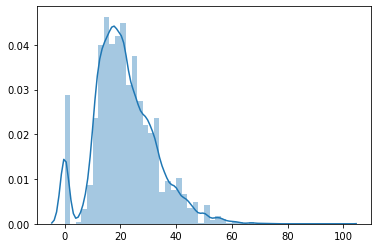

In [14]:
sns.distplot(gamename_matchlist)

In [15]:
finalgamelist_df.iloc[possiblegame_idx,2]

371    Catan
Name: game_name, dtype: object

In [18]:
possiblegame_idx

[371]

In [20]:
x = pd.DataFrame({'idx':finalgamelist_df.index,'matchnum':gamename_matchlist})

In [22]:
x.sort_values(by='matchnum',ascending=False,inplace=True)

In [25]:
xx=finalgamelist_df.iloc[x['idx'],2]

In [28]:
x

,idx,matchnum
371,371,100
15831,15831,73
7854,7854,73
7830,7830,73
3609,3609,71
...,...,...
17389,17389,0
8900,8900,0
4631,4631,0
17385,17385,0


100

In [33]:
qltynum=44
if qltynum>95:
    qltytext = 'great'
elif (qltynum>90) & (qltynum<=95):
    qltytext = 'fair'
elif (qltynum>80) & (qltynum<=90):
    qltytext = 'poor'
else:
    qltytext = 'terrible'

qltytext

'terrible'